# (Deep) CNNs for Image Colorization

### Import all the libraries

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Activation
from keras.layers import Dropout
from keras.optimizers import Adam
import time
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
import pickle
from sklearn.cluster import KMeans
from skimage import io
from keras.callbacks import Callback
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Ques (a)
This assignment uses a convolutional neural network for image colorization which turns a grayscale image to a colored image.4 By converting an image to grayscale, we lose color information, so converting a grayscale image back to a colored version is not an easy job. We will use the CIFAR-10 dataset. Downolad the dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving data_batch_4 to data_batch_4
Saving data_batch_5 to data_batch_5
Saving data_batch_3 to data_batch_3
Saving batches.meta to batches.meta
Saving data_batch_2 to data_batch_2
Saving test_batch to test_batch
Saving data_batch_1 to data_batch_1
User uploaded file "data_batch_4" with length 31035696 bytes
User uploaded file "data_batch_5" with length 31035623 bytes
User uploaded file "data_batch_3" with length 31035999 bytes
User uploaded file "batches.meta" with length 158 bytes
User uploaded file "data_batch_2" with length 31035320 bytes
User uploaded file "test_batch" with length 31035526 bytes
User uploaded file "data_batch_1" with length 31035704 bytes


Load dataset

In [0]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
def read_files():
    dataset_temp = unpickle("./test_batch")
    dataset = np.array(dataset_temp[b'data'])
    labels = np.array(dataset_temp[b'labels'])
    for i in range(1,6):
        dataset_temp = unpickle("./data_batch_"+str(i))
        dataset = np.append(dataset, dataset_temp[b'data'], axis=0)
        labels = np.append(labels, dataset_temp[b'labels'], axis=0)
    return dataset, labels

In [0]:
dataset, labels = read_files()

60k images of shape 3072, 60k labels

In [6]:
dataset.shape, labels.shape

((60000, 3072), (60000,))

### Ques (b)
From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

Label of bird?

In [7]:
label_def = np.array(unpickle("./batches.meta")[b'label_names'])
cls_name = 'bird'
print(label_def)
bird_label = np.where(label_def == cls_name.encode())[0][0]
"The label number of " + cls_name + " is " + str(bird_label)

[b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']


'The label number of bird is 2'

Extracting only bird images. Finding bird indices.

In [8]:
bird_idxs = np.where(labels == bird_label)[0]
print(bird_idxs, "\nShape: ", np.array(bird_idxs).shape)

[   25    35    65 ... 59987 59991 59995] 
Shape:  (6000,)


Taking only bird images

In [9]:
dataset_bird = np.take(dataset, bird_idxs, axis=0)
dataset_bird.shape

(6000, 3072)

Reshaping 3072 -> 1024 x 3

In [0]:
def reshape_rgb(dataset_):
    reshaped = np.empty([dataset_.shape[0], 1024, 3])
    for index, i in enumerate(dataset_):
        reshaped[index] = dataset_[index].reshape(-1, 1024).T
    return reshaped

In [11]:
trial = np.array(list(range(1, 3073)))
trial = np.array([trial, trial, trial])
print("Original Dataset shape :", dataset_bird.shape)
reshaped_bird = reshape_rgb(dataset_bird)
print("RGB Dataset shape      :", reshaped_bird.shape)

Original Dataset shape : (6000, 3072)
RGB Dataset shape      : (6000, 1024, 3)


reshaped_bird will be used for CNN too. <br>For now, flattening it to get just the pixels for Kmeans

In [12]:
just_pixels = reshaped_bird.reshape(-1, 3)
print("Just Pixels array shape :", just_pixels.shape)

Just Pixels array shape : (6144000, 3)


### Ques (c)
Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all of the pixels. You will have between P = 614400 and P = 6144000 pixels. Each pixel is an RGB vector with three elements.

Getting random pixels from flattened array.
<br>For now, it is 10%

In [0]:
def get_random_pixels(dataset_, percentage=0.1):
    leng = dataset_.shape[0]
    idxs = np.array([i for i in range(leng)])
    np.random.shuffle(idxs)
    idxs = idxs[:int(percentage*leng)]
    return np.take(dataset_, idxs, axis=0)

In [14]:
subset_bird_pixels = get_random_pixels(just_pixels, percentage=0.1)
print("Subset shape :", subset_bird_pixels.shape)
subset_bird_pixels[:10]

Subset shape : (614400, 3)


array([[175., 232., 254.],
       [146., 145.,  82.],
       [155., 135.,  88.],
       [128., 122.,  94.],
       [141., 169., 116.],
       [118., 148.,  84.],
       [143., 132., 110.],
       [160., 167., 173.],
       [105.,  92.,  84.],
       [141., 133., 118.]])

We now have array of shape (percentage*length) x 3. We will use this for Kmeans

# Kmeans
### Ques (d)
Run k-means clustering on the P vectors using k = 4. The centers of the clusters will be your main colors. Convert the colored images to k-color images by con- verting each pixel’s value to the closest main color in terms of Euclidean distance. These are the outputs of your network, whose each pixel falls in one of those k classes.

In [15]:
kmeans = KMeans(n_clusters=4, n_init=50).fit(subset_bird_pixels)
kmeans.cluster_centers_

array([[156.93938279, 156.50463606, 137.03378216],
       [ 49.42379867,  50.42501961,  38.91154489],
       [109.90210104, 109.42511599,  83.26692374],
       [207.57381988, 212.7236665 , 212.26812394]])

[[156 156 137]
 [ 49  50  38]
 [109 109  83]
 [207 212 212]]


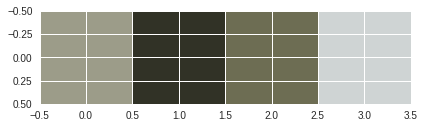

In [16]:
center_colors = np.uint8(kmeans.cluster_centers_)
print(center_colors)
indices = np.array(range(len(center_colors))).reshape(-1, 4)
io.imshow(center_colors[indices])

replacing colors in pictures

In [0]:
def recolor_images(reshaped_, center_colors, kmeans):
    reshaped_ = reshaped_.copy()
    nn_output = np.empty((reshaped_.shape[0], 1024))
    print(nn_output.shape)
    for index in range(reshaped_.shape[0]):
        new_colors = kmeans.predict(reshaped_[index])
        nn_output[index] = new_colors
        j = center_colors[new_colors]
        reshaped_[index] = j
    return np.uint8(reshaped_), nn_output

In [18]:
reshaped_bird.shape

(6000, 1024, 3)

In [19]:
kmeans_colored, color_output = recolor_images(reshaped_bird, center_colors, kmeans)
print(kmeans_colored.shape, color_output.shape)

(6000, 1024)
(6000, 1024, 3) (6000, 1024)


### Ques (e)
Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images. The grayscale images are inputs of your network.

In [20]:
grayscale_colored = rgb2gray(reshaped_bird)
grayscale_colored.shape

(6000, 1024)

### Results till now
We have 
1.   Original Image
2.   A recolored bird image according to KMeans centroid colors
3.   A grayscale image derived from the original image
   
We will see all the three images of every sample below, for first 5 samples.



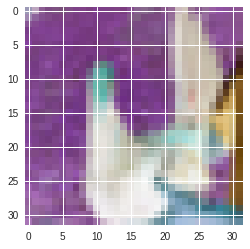

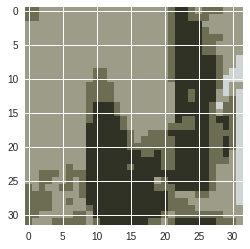

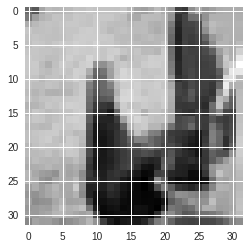

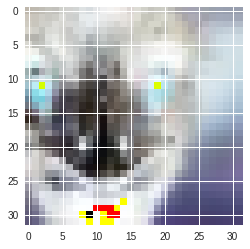

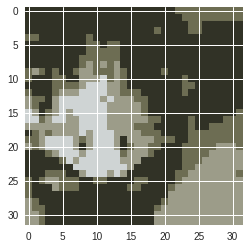

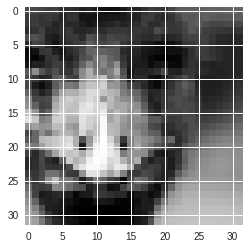

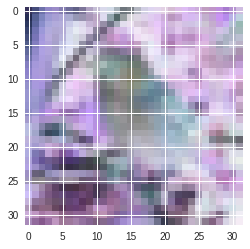

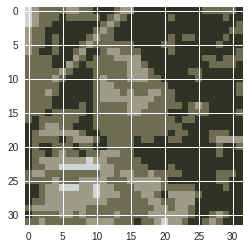

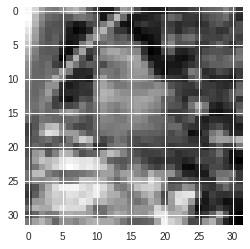

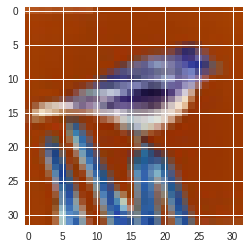

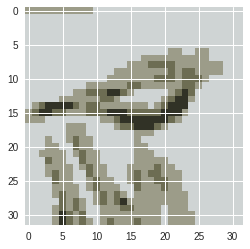

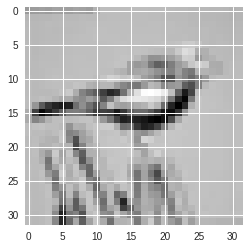

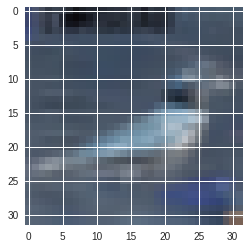

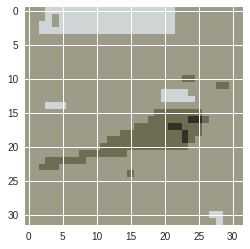

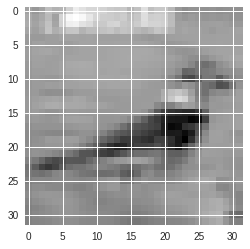

In [21]:
for i in range(5):
    plt.imshow(reshaped_bird[i].reshape(32, 32, 3))
    plt.show()
    plt.imshow(kmeans_colored[i].reshape(32, 32, 3))
    plt.show()
    plt.imshow(grayscale_colored[i].reshape(32, 32), cmap='gray')
    plt.show()
    

### Ques (f)
Set up a deep convolutional neural network with two convolution layers and two MLP layers with. Use 5 × 5 filters and a softmax layer. Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Your input is a grayscale version of an image (32 × 32 × 1) and the output is a 32 × 32 × 3 image that is colored using the main colors. Use a classification scheme, which means your output must determine one of the k color classes for each pixel in your grayscale image. Train at least for 5 epochs. Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

Here, the first 1000 samples are separated as test set because the corpus was created having test set before the training set.

In [22]:
nn_input = grayscale_colored.reshape(-1, 32, 32, 1)

ohe_output = np_utils.to_categorical(color_output).reshape(-1, 4096)
nn_output = ohe_output.reshape(-1, 1024, 4)


nn_input_test = nn_input[:1000]
nn_output_test = nn_output[:1000]
nn_input = nn_input[1000:]
nn_output = nn_output[1000:]

print("Input shape :", nn_input.shape)
print("Output Shape:", nn_output.shape)

Input shape : (5000, 32, 32, 1)
Output Shape: (5000, 1024, 4)


#### CNN input and output configuration
NN_input = grayscale_colored shape(6000, 1024)

NN_output = ohe_output shape (6000, 1024, 4) every 4 neurons for one pixel, 1 color<br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
            kmeans_colored shape(6000, 1024) output of neural network. Required for categorical cross entropy loss.

NN_original = reshaped_bird shape(6000, 1024, 3)

#### Call back list:
1. Model Checkpointing callback. It will save the weights of the best model.
2. Test Evaluation callback. This custom class will save the test loss after every epoch.

In [0]:
filepath="weights.best.hdf5"



class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        print('\nTesting loss: {}\n'.format(loss))
        
    def return_test(self):
        return self.test_loss

test_callback = TestCallback((nn_input_test, nn_output_test))
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, test_callback]

Function to create model. The model is created based on the requirements in the question.

In [0]:
def create_model():
    regressor = Sequential()
    
    regressor.add(Conv2D(filters=10, kernel_size=5, strides=(1, 1), padding='valid', input_shape=(32, 32, 1)))
    regressor.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    regressor.add(Dropout(0.2))
    
    regressor.add(Conv2D(filters=10, kernel_size=5, strides=(1, 1), padding='valid'))
    regressor.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
    regressor.add(Dropout(0.2))
    
    regressor.add(Flatten())
    
    regressor.add(Dense(units = 4096))
    regressor.add(Dropout(0.2))
    
    regressor.add(Dense(units = 4096))
    regressor.add(Dropout(0.2))
    regressor.add(Reshape((-1, 4)))
    
    regressor.add(Activation('softmax'))
    
    regressor.compile(optimizer = Adam(), loss = 'categorical_crossentropy')
    return regressor

In [42]:
regressor = create_model()
regressor

The final input and output shape for the model. 5000 represents the number of samples in training.

In [43]:
nn_input.shape, nn_output.shape

((5000, 32, 32, 1), (5000, 1024, 4))

Trained for 100 epochs. after each epoch, train, validation and test errors are logged.

In [44]:
history = regressor.fit(nn_input, nn_output, validation_split=0.33, batch_size=900, epochs=100, callbacks=callbacks_list, verbose=1)

Train on 3349 samples, validate on 1651 samples
Epoch 1/100
3349/3349 [==============================] - 1s 370us/step - loss: 9.8157 - val_loss: 7.5300

Epoch 00001: val_loss improved from inf to 7.52997, saving model to weights.best.hdf5

Testing loss: 7.610360702514648

Epoch 2/100
3349/3349 [==============================] - 1s 164us/step - loss: 7.6096 - val_loss: 7.8177

Epoch 00002: val_loss did not improve from 7.52997

Testing loss: 7.937023300170899

Epoch 3/100
3349/3349 [==============================] - 1s 154us/step - loss: 6.5487 - val_loss: 6.9623

Epoch 00003: val_loss improved from 7.52997 to 6.96228, saving model to weights.best.hdf5

Testing loss: 7.089818817138672

Epoch 4/100
3349/3349 [==============================] - 1s 151us/step - loss: 5.6871 - val_loss: 6.4982

Epoch 00004: val_loss improved from 6.96228 to 6.49817, saving model to weights.best.hdf5

Testing loss: 6.624945610046387

Epoch 5/100
3349/3349 [==============================] - 1s 153us/step - lo


Testing loss: 1.1341976222991943

Epoch 14/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.4187 - val_loss: 1.0981

Epoch 00014: val_loss improved from 1.12641 to 1.09807, saving model to weights.best.hdf5

Testing loss: 1.1064982166290283

Epoch 15/100
3349/3349 [==============================] - 1s 152us/step - loss: 1.3799 - val_loss: 1.0994

Epoch 00015: val_loss did not improve from 1.09807

Testing loss: 1.1105430517196655

Epoch 16/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.3397 - val_loss: 1.0696

Epoch 00016: val_loss improved from 1.09807 to 1.06956, saving model to weights.best.hdf5

Testing loss: 1.0784626693725585

Epoch 17/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.3106 - val_loss: 1.0624

Epoch 00017: val_loss improved from 1.06956 to 1.06242, saving model to weights.best.hdf5

Testing loss: 1.0715901718139649

Epoch 18/100
3349/3349 [==============================] - 1s 154us/step - lo

3349/3349 [==============================] - 1s 155us/step - loss: 1.1891 - val_loss: 1.0206

Epoch 00026: val_loss did not improve from 1.01634

Testing loss: 1.022424340248108

Epoch 27/100
3349/3349 [==============================] - 1s 152us/step - loss: 1.1794 - val_loss: 1.0338

Epoch 00027: val_loss did not improve from 1.01634

Testing loss: 1.0394569759368897

Epoch 28/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.1723 - val_loss: 1.0311

Epoch 00028: val_loss did not improve from 1.01634

Testing loss: 1.0439773006439208

Epoch 29/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.1670 - val_loss: 1.0530

Epoch 00029: val_loss did not improve from 1.01634

Testing loss: 1.066526948928833

Epoch 30/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.1601 - val_loss: 1.0343

Epoch 00030: val_loss did not improve from 1.01634

Testing loss: 1.0441798896789551

Epoch 31/100
3349/3349 [==========================

3349/3349 [==============================] - 1s 156us/step - loss: 1.1130 - val_loss: 0.9910

Epoch 00039: val_loss improved from 0.99540 to 0.99100, saving model to weights.best.hdf5

Testing loss: 0.9931583452224731

Epoch 40/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.1069 - val_loss: 1.0035

Epoch 00040: val_loss did not improve from 0.99100

Testing loss: 1.0111701183319093

Epoch 41/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.0984 - val_loss: 0.9923

Epoch 00041: val_loss did not improve from 0.99100

Testing loss: 0.9977883548736572

Epoch 42/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.0993 - val_loss: 0.9869

Epoch 00042: val_loss improved from 0.99100 to 0.98689, saving model to weights.best.hdf5

Testing loss: 0.9938155632019043

Epoch 43/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.0901 - val_loss: 0.9689

Epoch 00043: val_loss improved from 0.98689 to 0.96889, 


Epoch 00051: val_loss did not improve from 0.96889

Testing loss: 0.9939860754013061

Epoch 52/100
3349/3349 [==============================] - 1s 158us/step - loss: 1.0625 - val_loss: 0.9936

Epoch 00052: val_loss did not improve from 0.96889

Testing loss: 1.0017740230560304

Epoch 53/100
3349/3349 [==============================] - 1s 153us/step - loss: 1.0539 - val_loss: 0.9702

Epoch 00053: val_loss did not improve from 0.96889

Testing loss: 0.9713393144607544

Epoch 54/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.0542 - val_loss: 0.9599

Epoch 00054: val_loss improved from 0.96889 to 0.95995, saving model to weights.best.hdf5

Testing loss: 0.96700217628479

Epoch 55/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.0557 - val_loss: 0.9930

Epoch 00055: val_loss did not improve from 0.95995

Testing loss: 1.0000628309249877

Epoch 56/100
3349/3349 [==============================] - 1s 156us/step - loss: 1.0585 - val_loss: 0.970

3349/3349 [==============================] - 1s 154us/step - loss: 1.0349 - val_loss: 0.9405

Epoch 00064: val_loss did not improve from 0.92117

Testing loss: 0.9468780469894409

Epoch 65/100
3349/3349 [==============================] - 1s 156us/step - loss: 1.0282 - val_loss: 0.9610

Epoch 00065: val_loss did not improve from 0.92117

Testing loss: 0.9695550384521484

Epoch 66/100
3349/3349 [==============================] - 1s 156us/step - loss: 1.0210 - val_loss: 0.9455

Epoch 00066: val_loss did not improve from 0.92117

Testing loss: 0.9530234446525574

Epoch 67/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.0237 - val_loss: 0.9149

Epoch 00067: val_loss improved from 0.92117 to 0.91486, saving model to weights.best.hdf5

Testing loss: 0.9211967477798462

Epoch 68/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.0211 - val_loss: 0.9773

Epoch 00068: val_loss did not improve from 0.91486

Testing loss: 0.9852739009857178

Epoch 69/


Epoch 00076: val_loss did not improve from 0.91486

Testing loss: 0.9347025518417358

Epoch 77/100
3349/3349 [==============================] - 1s 156us/step - loss: 1.0079 - val_loss: 0.9183

Epoch 00077: val_loss did not improve from 0.91486

Testing loss: 0.9245201196670533

Epoch 78/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.0055 - val_loss: 0.9176

Epoch 00078: val_loss did not improve from 0.91486

Testing loss: 0.9312765226364136

Epoch 79/100
3349/3349 [==============================] - 1s 154us/step - loss: 0.9988 - val_loss: 0.9150

Epoch 00079: val_loss did not improve from 0.91486

Testing loss: 0.923883973121643

Epoch 80/100
3349/3349 [==============================] - 1s 156us/step - loss: 0.9983 - val_loss: 0.9719

Epoch 00080: val_loss did not improve from 0.91486

Testing loss: 0.9858853511810303

Epoch 81/100
3349/3349 [==============================] - 1s 154us/step - loss: 1.0260 - val_loss: 0.9747

Epoch 00081: val_loss did not impro


Epoch 00089: val_loss improved from 0.89680 to 0.89111, saving model to weights.best.hdf5

Testing loss: 0.8982323942184448

Epoch 90/100
3349/3349 [==============================] - 1s 152us/step - loss: 0.9928 - val_loss: 0.8944

Epoch 00090: val_loss did not improve from 0.89111

Testing loss: 0.8985937576293945

Epoch 91/100
3349/3349 [==============================] - 1s 152us/step - loss: 0.9899 - val_loss: 0.9057

Epoch 00091: val_loss did not improve from 0.89111

Testing loss: 0.9112135071754456

Epoch 92/100
3349/3349 [==============================] - 1s 153us/step - loss: 0.9898 - val_loss: 0.9064

Epoch 00092: val_loss did not improve from 0.89111

Testing loss: 0.9151880016326904

Epoch 93/100
3349/3349 [==============================] - 1s 152us/step - loss: 0.9969 - val_loss: 0.9098

Epoch 00093: val_loss did not improve from 0.89111

Testing loss: 0.9151767597198487

Epoch 94/100
3349/3349 [==============================] - 1s 155us/step - loss: 1.0155 - val_loss: 0.9

#### Plot
Plotting train, validation and test errors. It can be observed that because of dropout, the model is not overfit and validation and test errors are very similar and hence overlap.

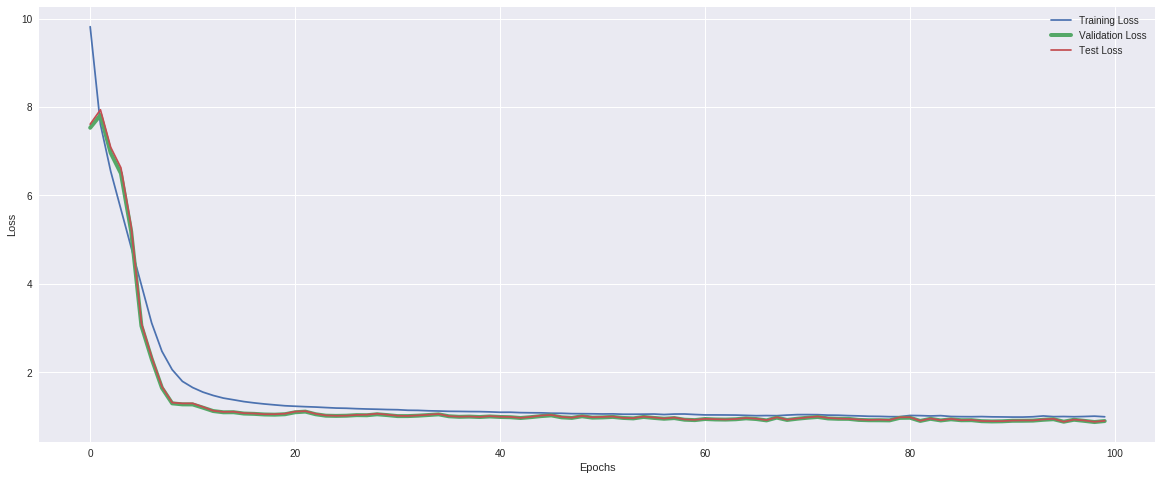

In [64]:
width = 20
height = 8
plt.figure(figsize=(width, height))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=4.0)
plt.plot(test_callback.return_test(), label='Test Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

Method to take model's prediction and convert it into a printable np array.

In [0]:
def print_output_image(vec, center_colors):
  img = np.empty((vec.shape[0], 3))
  for index, pixel in enumerate(vec):
    idx = np.where(pixel == max(pixel))
    img[index] = center_colors[idx]
  img = np.uint8(img.reshape(32, 32, 3))

  return img

We load the best weights into the regressor and then evaluate on train and test accuracy

In [51]:
regressor.load_weights("weights.best.hdf5")
print("Best train loss :", regressor.evaluate(nn_input, nn_output, verbose=0))
print("Best test loss  :", regressor.evaluate(nn_input_test, nn_output_test, verbose=0))

Best train loss : 0.8294595865249634
Best test loss  : 0.8833256063461303


Please keep in mind that this loss is not on a scale of 0-1 but rather, on a scale 0-1024(I think so.) Loss will be 1024 when every pixel is predicted incorrectly. 

### Print 10 test images
We predict first 10 images in the test set. <br>
Then, we print them side by side with the original k-color image for observation.


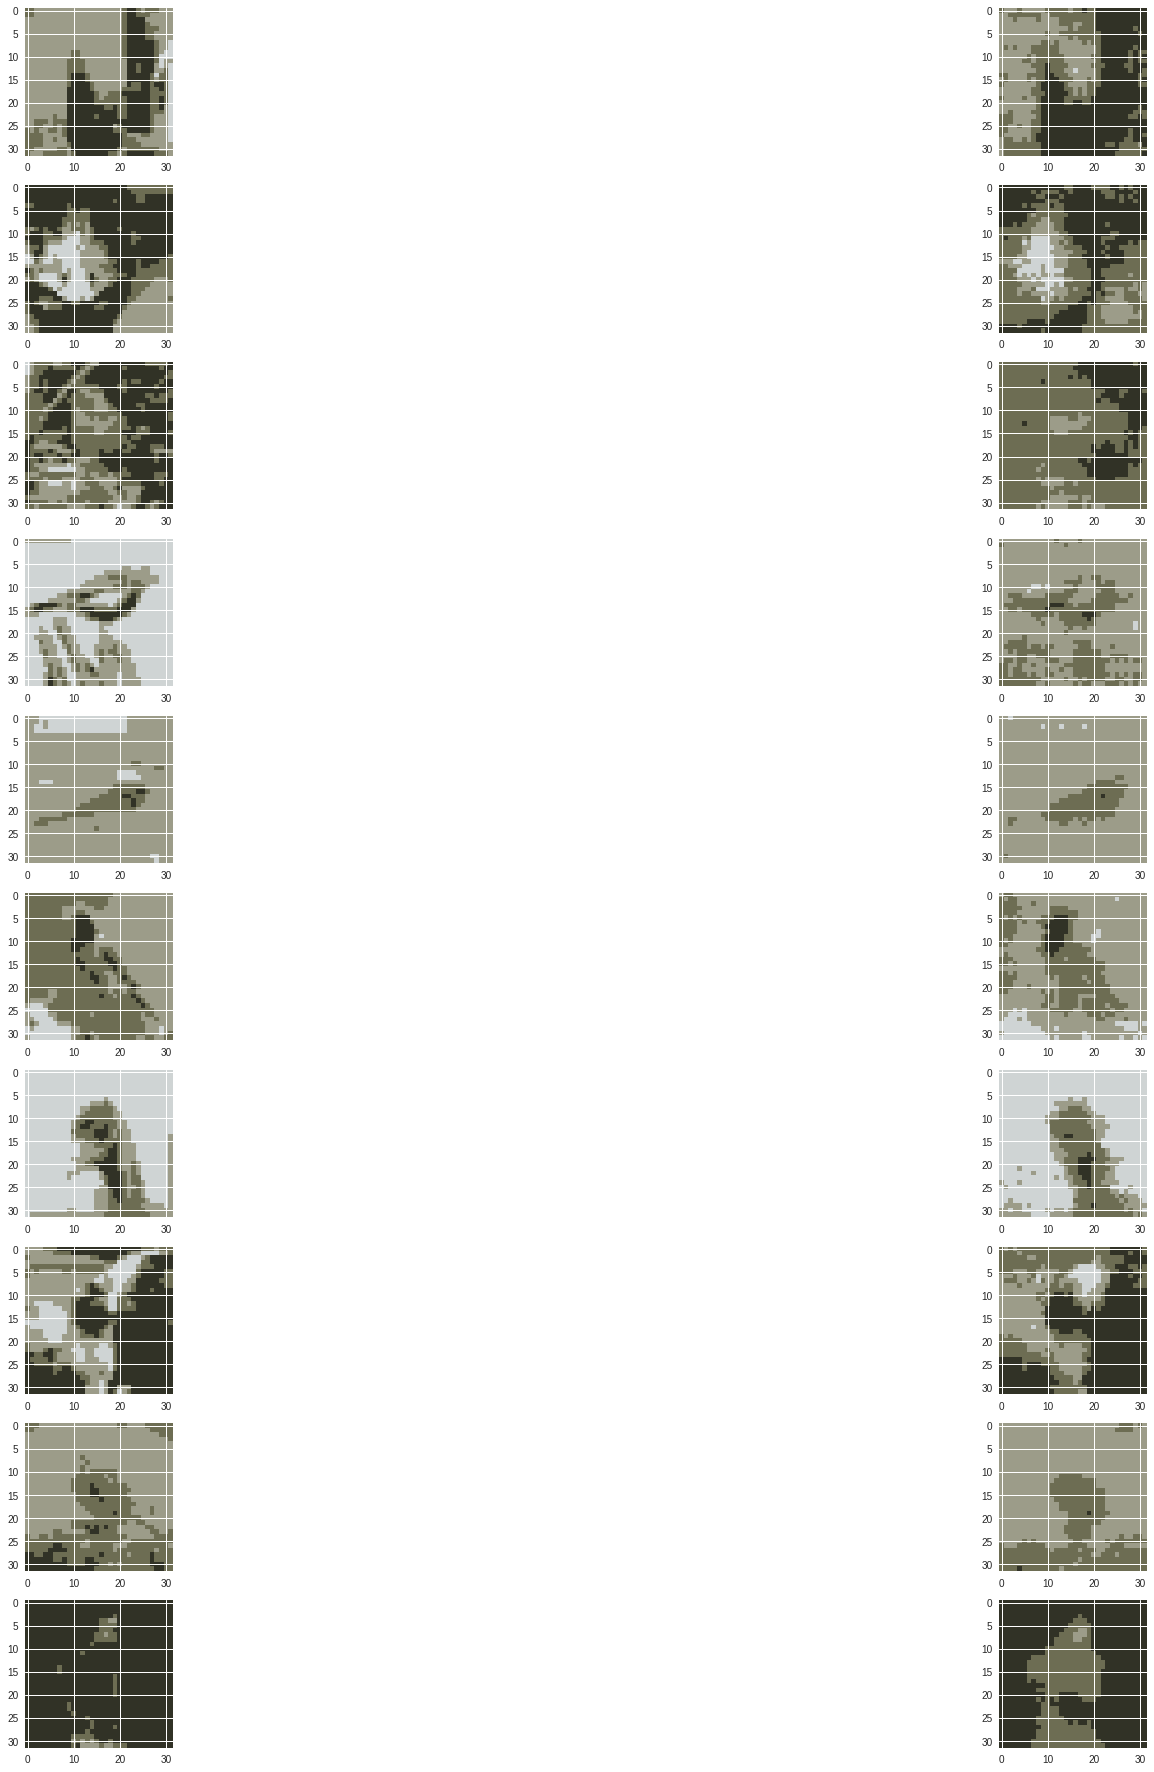

In [52]:
pred = regressor.predict(nn_input_test[:10])
f,ax = plt.subplots(len(pred), 2, figsize=(32,32))
for i in range(len(pred)):
    ax[i][0].imshow(kmeans_colored[i].reshape(32, 32, 3))
    ax[i][1].imshow(print_output_image(pred[i], center_colors))
plt.show()
